<a href="https://colab.research.google.com/github/Ackasi21/Playground/blob/main/TFX_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network

## Part 1 - Data Preprocessing

### Importing the libraries

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the training set

In [33]:
dataset = pd.read_csv('PJME_hourly.csv')

dataset['Datetime'] = pd.to_datetime(dataset['Datetime'], format='%Y-%m-%d %H:%M:%S')

dataset.set_index('Datetime', inplace=True)

training_data = dataset[dataset.index.year < 2018]['PJME_MW']
test_data = dataset[dataset.index.year == 2018]['PJME_MW']

training_set = training_data.values.reshape(-1, 1)
test_set = test_data.values.reshape(-1, 1)

### Feature Scaling

In [34]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Creating a data structure with 60 timesteps and 1 output

In [35]:
X_train = []
y_train = []
for i in range(168, 140230):
    X_train.append(training_set_scaled[i-168:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [36]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Part 2 - Building and Training the RNN

### Importing the Keras libraries and packages

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Initialising the RNN

In [38]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [39]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [40]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [41]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [42]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Adding the output layer

In [43]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [44]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [46]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    filepath='best_model2.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

history = regressor.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/100
3500/3502 [============================>.] - ETA: 0s - loss: 0.0042
Epoch 1: val_loss improved from inf to 0.00155, saving model to best_model2.h5
3502/3502 [==============================] - 96s 27ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 2/100
3501/3502 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 2: val_loss improved from 0.00155 to 0.00044, saving model to best_model2.h5
3502/3502 [==============================] - 92s 26ms/step - loss: 0.0012 - val_loss: 4.4142e-04
Epoch 3/100
3501/3502 [============================>.] - ETA: 0s - loss: 6.7598e-04
Epoch 3: val_loss improved from 0.00044 to 0.00032, saving model to best_model2.h5
3502/3502 [==============================] - 93s 26ms/step - loss: 6.7595e-04 - val_loss: 3.2163e-04
Epoch 4/100
3500/3502 [============================>.] - ETA: 0s - loss: 5.3612e-04
Epoch 4: val_loss improved from 0.00032 to 0.00026, saving model to best_model2.h5
3502/3502 [==============================] - 93s 27ms

## Part 3 - Making the predictions and visualising the results

In [47]:
from google.colab import files

files.download('best_model2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Getting the real energy usage in 2018

In [28]:
regressor.load_weights('best_model.h52')


### Getting the energy usage of 2018

In [48]:
inputs = test_data.values.reshape(-1, 1)
inputs = sc.transform(inputs)

X_test = []
for i in range(168, len(inputs)):
    X_test.append(inputs[i-168:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_energy = regressor.predict(X_test)
predicted_energy = sc.inverse_transform(predicted_energy)


156/156 [==============================] - 3s 10ms/step


### Visualising the results (Short Time Span)


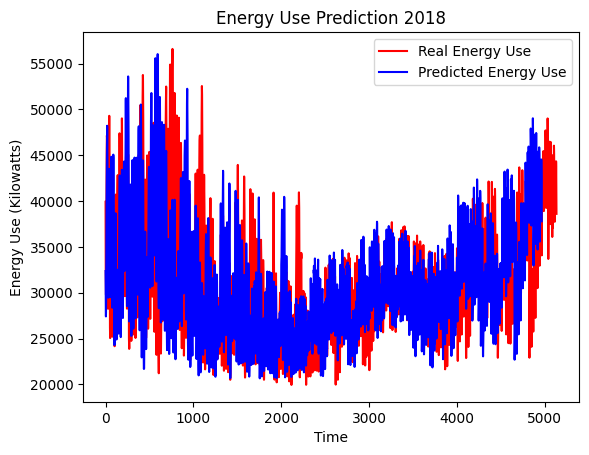

In [49]:
plt.plot(test_data.values, color='red', label='Real Energy Use')
plt.plot(predicted_energy, color='blue', label='Predicted Energy Use')
plt.title('Energy Use Prediction 2018')
plt.xlabel('Time')
plt.ylabel('Energy Use (Kilowatts)')
plt.legend()
plt.show()

### Visualising the results (Overall Fit)


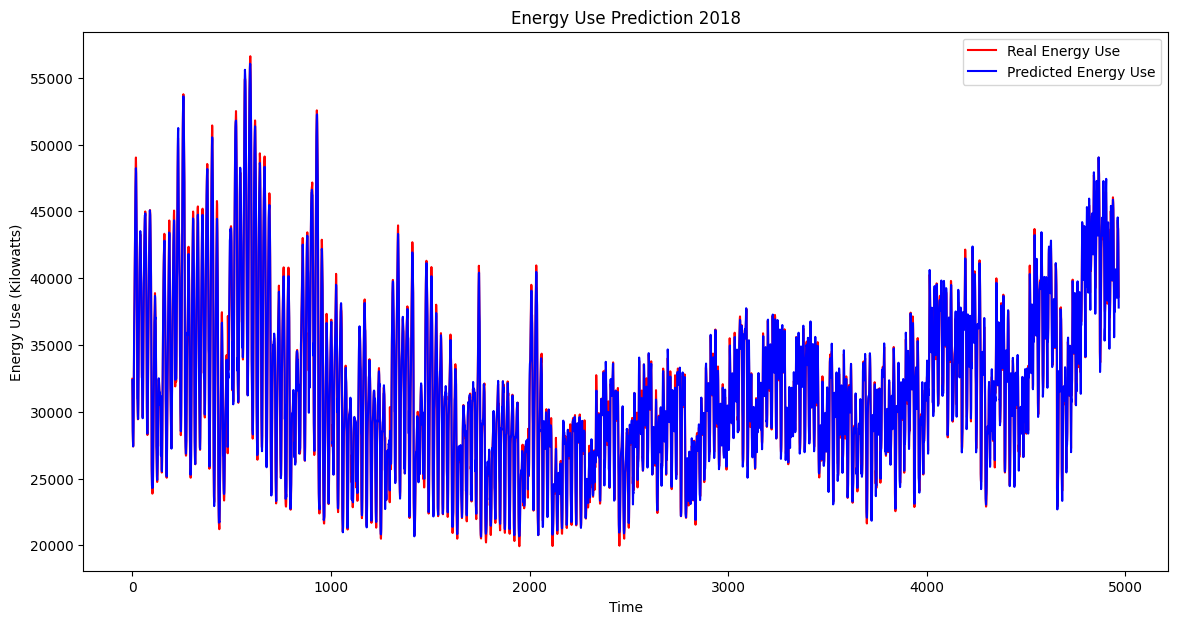

In [51]:

aligned_test_data = test_data.values[168:]

plt.figure(figsize=(14, 7))
plt.plot(aligned_test_data, color='red', label='Real Energy Use')
plt.plot(predicted_energy, color='blue', label='Predicted Energy Use')
plt.title('Energy Use Prediction 2018')
plt.xlabel('Time')
plt.ylabel('Energy Use (Kilowatts)')
plt.legend()
plt.show()
